<a href="https://colab.research.google.com/github/liu-feng116/EvaluateModels/blob/main/X3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.import模块

In [ ]:
try:
    import torch
except ModuleNotFoundError:
    !pip install torch torchvision
    import os
    import sys
    import torch
    
if torch.__version__=='1.6.0+cu101' and sys.platform.startswith('linux'):
    !pip install pytorchvideo
else:
    need_pytorchvideo=False
    try:
        # Running notebook locally
        import pytorchvideo
    except ModuleNotFoundError:
        need_pytorchvideo=True
    if need_pytorchvideo:
        # Install from GitHub
        !pip install "git+https://github.com/facebookresearch/pytorchvideo.git"

import json 
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
) 
from typing import Dict

2.下载测试数据集

In [ ]:
!wget https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json
with open("kinetics_classnames.json", "r") as f:
    kinetics_classnames = json.load(f)

# 对数据集标签进行处理
kinetics_id_to_classname = {}
for k, v in kinetics_classnames.items():
    kinetics_id_to_classname[v] = str(k).replace('"', "")

--2021-11-07 16:04:57--  https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10326 (10K) [text/plain]
Saving to: ‘kinetics_classnames.json.2’

kinetics_classnames 100%[===================>]  10.08K  --.-KB/s    in 0s      

2021-11-07 16:04:57 (53.2 MB/s) - ‘kinetics_classnames.json.2’ saved [10326/10326]



3.利用Torch Hub加载预处理模型，这里选择根据tutorial先测试slowfast

In [ ]:
def get_model(device, model_name):
  # 从torch hub导入model
  model = torch.hub.load("facebookresearch/pytorchvideo:main", model=model_name, pretrained=True)
  # 设置eval（测试），设置设备
  model = model.to(device)
  model = model.eval()
  return model

4.加载example video

In [ ]:
# 下载example video
!wget https://dl.fbaipublicfiles.com/pytorchvideo/projects/archery.mp4

--2021-11-07 16:04:57--  https://dl.fbaipublicfiles.com/pytorchvideo/projects/archery.mp4
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 549197 (536K) [video/mp4]
Saving to: ‘archery.mp4.1’

archery.mp4.1       100%[===================>] 536.33K  2.13MB/s    in 0.2s    

2021-11-07 16:04:58 (2.13 MB/s) - ‘archery.mp4.1’ saved [549197/549197]



5.设置输入变换（input transformation）并对视频切片

In [ ]:
def clip(video_path, start_sec, device, model_name):
  # 设置输入变换（input transformation）
  mean = [0.45, 0.45, 0.45]
  std = [0.225, 0.225, 0.225]
  frames_per_second = 30
  model_transform_params  = {
      "x3d_xs": {
          "side_size": 182,
          "crop_size": 182,
          "num_frames": 4,
          "sampling_rate": 12,
      },
      "x3d_s": {
          "side_size": 182,
          "crop_size": 182,
          "num_frames": 13,
          "sampling_rate": 6,
      },
      "x3d_m": {
          "side_size": 256,
          "crop_size": 256,
          "num_frames": 16,
          "sampling_rate": 5,
      }
  }

  # Get transform parameters based on model
  transform_params = model_transform_params[model_name]

  # Note that this transform is specific to the slow_R50 model.
  transform =  ApplyTransformToKey(
      key="video",
      transform=Compose(
          [
              UniformTemporalSubsample(transform_params["num_frames"]),
              Lambda(lambda x: x/255.0),
              NormalizeVideo(mean, std),
              ShortSideScale(size=transform_params["side_size"]),
              CenterCropVideo(
                  crop_size=(transform_params["crop_size"], transform_params["crop_size"])
              )
          ]
      ),
  )

  # The duration of the input clip is also specific to the model.
  clip_duration = (transform_params["num_frames"] * transform_params["sampling_rate"])/frames_per_second

  # 对视频进行切片处理
  # 选择要加载的切片的持续时间。
  end_sec = start_sec + clip_duration 
  # 初始化EncodeVideo类
  video = EncodedVideo.from_path(video_path)
  # 加载所需的切片数据
  video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)
  # 应用此前设置的输入变换处理切片数据
  video_data = transform(video_data)
  # 将切片数据加载到cpu内存
  inputs = video_data["video"]
  inputs = inputs.to(device)
  return inputs

6.进行prediction

In [ ]:
import time
time_list = []
mean_time = 0.0
model_list = ["x3d_xs", "x3d_s", "x3d_m"]
for model_name in model_list:
  print("-----------------------")
  print("The model of %s is running:" % model_name)
  # 开始预测
  for i in range(10):
    # 向model导入切片数据
    inputs = clip("archery.mp4", 0, "cpu", model_name)
    model = get_model("cpu", model_name)

    # 开始计时
    start = time.clock()

    preds = model(inputs[None, ...])

    # 结束计时
    end = time.clock()

    # 累计求和
    mean_time = mean_time + (end - start)

    # 获得预测类别
    post_act = torch.nn.Softmax(dim=1)
    preds = post_act(preds)
    pred_classes = preds.topk(k=5).indices
    print(pred_classes)

    # 通过kineticss_id_to_classname获取对应indices的label
    pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes[0]]
    print("%d round:" % i )
    print("Predicted labels: %s" % ", ".join(pred_class_names))
  
  # 平均
  mean_time = mean_time/10
  time_list.append(mean_time)
  print('time: %e' % mean_time)

-----------------------
The model of x3d_xs is running:


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tensor([[  5, 142, 141, 356,   3]])
0 round:
Predicted labels: archery, golf driving, golf chipping, throwing axe, applauding


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[  5, 142, 141, 356,   3]])
1 round:
Predicted labels: archery, golf driving, golf chipping, throwing axe, applauding


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[  5, 142, 141, 356,   3]])
2 round:
Predicted labels: archery, golf driving, golf chipping, throwing axe, applauding


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[  5, 142, 141, 356,   3]])
3 round:
Predicted labels: archery, golf driving, golf chipping, throwing axe, applauding


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[  5, 142, 141, 356,   3]])
4 round:
Predicted labels: archery, golf driving, golf chipping, throwing axe, applauding


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[  5, 142, 141, 356,   3]])
5 round:
Predicted labels: archery, golf driving, golf chipping, throwing axe, applauding


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[  5, 142, 141, 356,   3]])
6 round:
Predicted labels: archery, golf driving, golf chipping, throwing axe, applauding


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[  5, 142, 141, 356,   3]])
7 round:
Predicted labels: archery, golf driving, golf chipping, throwing axe, applauding


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[  5, 142, 141, 356,   3]])
8 round:
Predicted labels: archery, golf driving, golf chipping, throwing axe, applauding


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[  5, 142, 141, 356,   3]])
9 round:
Predicted labels: archery, golf driving, golf chipping, throwing axe, applauding
time: 4.000915e-01
-----------------------
The model of x3d_s is running:


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/X3D_S.pyth" to /root/.cache/torch/hub/checkpoints/X3D_S.pyth


  0%|          | 0.00/29.4M [00:00<?, ?B/s]

tensor([[5, 1, 3, 4, 0]])
0 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[5, 1, 3, 4, 0]])
1 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[5, 1, 3, 4, 0]])
2 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[5, 1, 3, 4, 0]])
3 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[5, 1, 3, 4, 0]])
4 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[5, 1, 3, 4, 0]])
5 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[5, 1, 3, 4, 0]])
6 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[5, 1, 3, 4, 0]])
7 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[5, 1, 3, 4, 0]])
8 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[5, 1, 3, 4, 0]])
9 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling
time: 1.283508e+00
-----------------------
The model of x3d_m is running:


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/X3D_M.pyth" to /root/.cache/torch/hub/checkpoints/X3D_M.pyth


  0%|          | 0.00/29.4M [00:00<?, ?B/s]

tensor([[5, 1, 3, 4, 0]])
0 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[5, 1, 3, 4, 0]])
1 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[5, 1, 3, 4, 0]])
2 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[5, 1, 3, 4, 0]])
3 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[5, 1, 3, 4, 0]])
4 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[5, 1, 3, 4, 0]])
5 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[5, 1, 3, 4, 0]])
6 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[5, 1, 3, 4, 0]])
7 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[5, 1, 3, 4, 0]])
8 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[5, 1, 3, 4, 0]])
9 round:
Predicted labels: archery, air drumming, applauding, applying cream, abseiling
time: 3.116712e+00


7.绘制图像

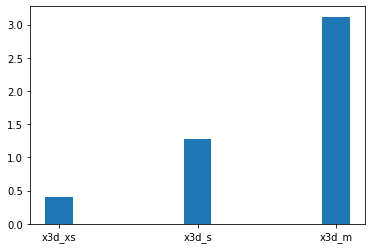

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.bar(model_list, time_list, width=0.2)
plt.show()